In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import pymc
import numpy as np
import pandas as pd
from general.DB import DB
import util
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
unstacked, stacked, teams = util.get_data(2013)

In [45]:
kenpom = pd.read_sql("SELECT adjt, team FROM kenpom_ranks WHERE year=2013", DB.conn)
all_teams = pd.read_sql("SELECT kenpom, ncaaid FROM teams", DB.conn)
kenpom = kenpom.merge(all_teams, left_on="team", right_on="kenpom")
kenpom.rename(columns={'ncaaid': 'team_id', 'adjt': 'pace'}, inplace=True)
kenpom.head()

,pace,team,kenpom,team_id
0,66.8,Louisville,Louisville,367
1,62.8,Florida,Florida,235
2,67.3,Indiana,Indiana,306
3,65.1,Michigan,Michigan,418
4,64.6,Gonzaga,Gonzaga,260


In [46]:
unstacked = unstacked.merge(kenpom[['team_id', 'pace']], left_on='hteam_id', right_on='team_id')
unstacked.rename(columns={'pace': 'home_adjt'}, inplace=True)
# unstacked.drop('team_id', inplace=True)
unstacked = unstacked.merge(kenpom[['team_id', 'pace']], left_on='ateam_id', right_on='team_id')
unstacked.rename(columns={'pace': 'away_adjt'}, inplace=True)
# unstacked.drop('team_id', 1)
unstacked.head()

,game_id,dt,hteam,hteam_id,ateam,ateam_id,hpts,hposs,apts,aposs,...,hppp,appp,neutral,home_outcome,poss,season,team_id_x,home_adjt,team_id_y,away_adjt
0,2035795,2013-04-08,Michigan,418,Louisville,367,76,63.875,82,65.925,...,1.189824,1.243838,True,False,64.9000,2013,418,65.1,367,66.8
1,1914455,2013-03-16,Syracuse,688,Louisville,367,61,63.350,78,66.100,...,0.962904,1.180030,True,False,64.7250,2013,688,64.2,367,66.8
2,1783192,2013-03-02,Syracuse,688,Louisville,367,53,64.700,58,65.400,...,0.819165,0.886850,False,False,65.0500,2013,688,64.2,367,66.8
3,2025015,2013-04-06,Wichita St.,782,Louisville,367,68,62.400,72,60.775,...,1.089744,1.184698,True,False,61.5875,2013,782,65.1,367,66.8
4,1991724,2013-03-31,Duke,193,Louisville,367,63,66.300,85,69.100,...,0.950226,1.230101,True,False,67.7000,2013,193,67.6,367,66.8


In [47]:
mean_poss = unstacked.poss.mean()
unstacked['kenpom_predicted'] = unstacked.apply(lambda row: \
    row.home_adjt * row.away_adjt / mean_poss, axis=1)
unstacked['kp_error'] =  unstacked.kenpom_predicted - unstacked.poss

4.94625938218


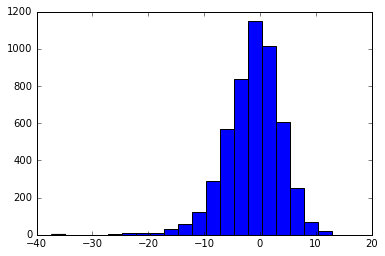

In [51]:
plt.hist(unstacked['kp_error'], bins=20)
print np.std(unstacked['kp_error'])
# unstacked.shape

In [6]:
pace_initial = stacked.groupby('iteam').mean()['poss'].values
teams['pace_initial'] = pace_initial

In [37]:
num_teams = teams.shape[0]
home_team_idx = unstacked.i_hteam.values
away_team_idx = unstacked.i_ateam.values
observed_pace = unstacked.poss.values
tau = 1. / pymc.Uniform('tau', 3., 20.)**2
pace_prior = pymc.Normal("pace_prior", mu=0, tau=tau, size=num_teams, value=pace_initial)
pace_intercept = pymc.Normal('intercept', 4, 1 / (1)**2, value=4)

@pymc.deterministic
def pace_rtg(pace=pace_prior):
    p = pace.copy()
    p = p - np.mean(pace)
    return p
        
@pymc.deterministic
def mu_pace(home_team=home_team_idx,
               away_team=away_team_idx,
               paces=pace_rtg,
               pace_intercept=pace_intercept):
    return pace_intercept + paces[home_team] + paces[away_team]

tau_poss = pymc.Uniform('tau_poss', (1 / 20)**0.5,(1 / 1)**0.5)
poss = pymc.Normal('poss', mu=mu_pace, tau=tau_poss, value=observed_pace, observed=True)
# poss = pymc.Poisson('poss', mu=mu_pace, value=observed_pace, observed=True)
poss_pred = pymc.Normal('poss_pred', mu=mu_pace, tau=tau_poss)


In [72]:
N_samples = 10000
burn_in = 0.3
model = pymc.Model([mu_pace, pace_prior, tau, pace_rtg, poss, pace_intercept, tau_poss, poss_pred])
map_ = pymc.MAP( model )
map_.fit() #stores the fitted variables' values in foo.value
mcmc = pymc.MCMC(model)
mcmc.sample(N_samples, burn_in * N_samples)

 [-----------------100%-----------------] 10000 of 10000 complete in 11.3 sec

In [73]:
teams['mean_pace_rtg'] = pace_rtg.stats()['mean']
teams['pace'] = pace_rtg.stats()['mean']
teams['pace2'] = teams.pace + pace_intercept.stats()['mean']

In [81]:
rank_sim, rate_sim, df = util.compare_ratings(teams, kenpom, 'pace', 'bayes', 'kp', metric='avg_diff')
rank_sim

avg_diff


21.256484149855908

Plotting intercept


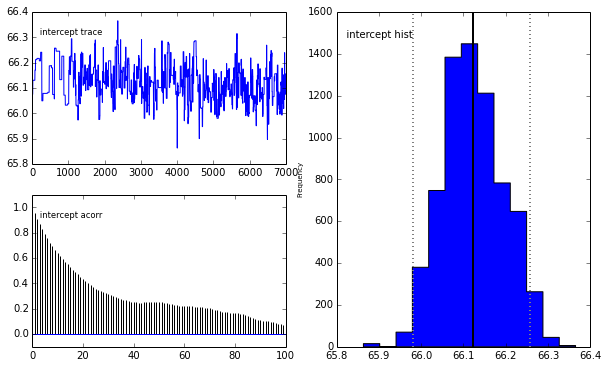

In [75]:
pymc.Matplot.plot(pace_intercept)

(array([ 0.00128536,  0.01327046,  0.04616869,  0.06461532,  0.04012403,
         0.01594539,  0.00396029,  0.00100744,  0.00031265,  0.00013896]),
 array([  47.3625,   52.715 ,   58.0675,   63.42  ,   68.7725,   74.125 ,
          79.4775,   84.83  ,   90.1825,   95.535 ,  100.8875]),
 <a list of 10 Patch objects>)

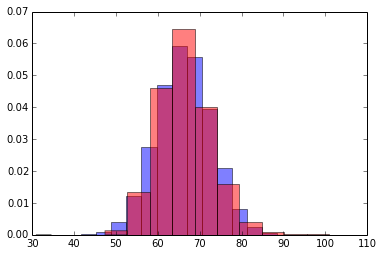

In [13]:
plt.hist(poss_pred.trace().ravel(), normed=True, alpha=0.5, bins=20)
# plt.hist(observed_pace)
plt.hist(observed_pace[~pd.isnull(observed_pace)], color='r', normed=True, alpha=0.5)

In [14]:
bteams = pd.read_sql("SELECT * FROM teams WHERE conf='B10'", DB.conn)
b10_teams = set(bteams.ncaaid.values)

In [25]:
games.head()

,game_id,dt,hteam,team_id_x,ateam,team_id_y,hpts,hposs,apts,aposs,i_hteam,i_ateam,poss
0,1999211,2013-04-02,Iowa,312,Maryland,392,71,63.400,60,64.600,1,83,64.0000
1,1948633,2013-03-22,Iowa,312,Stony Brook,683,75,62.975,63,63.075,1,234,63.0250
2,1942259,2013-03-20,Iowa,312,Indiana St.,305,68,65.350,52,65.225,1,54,65.2875
3,1871394,2013-03-09,Iowa,312,Nebraska,463,74,56.125,60,56.225,1,6,56.1750
4,1835252,2013-03-05,Iowa,312,Illinois,301,63,67.500,55,68.075,1,34,67.7875


In [118]:
games['pred'] = np.mean(poss_pred.trace(), axis=0)
trace = poss_pred.trace()
trace.shape

(7000, 5267)

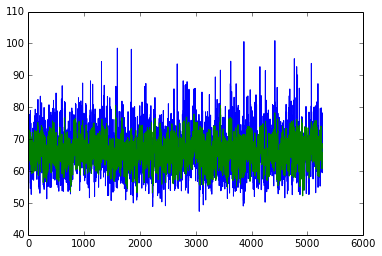

In [30]:
plt.plot(range(games.shape[0]), games.poss)
plt.plot(range(games.shape[0]), games.pred)

In [31]:
from sklearn.metrics import r2_score

In [32]:
r2_score(games.poss, games.pred)

0.38777394311599989

(array([   16.,    93.,   413.,  1195.,  1830.,  1760.,  1178.,   406.,
           94.,    15.]),
 array([ 65.7970665 ,  65.86804546,  65.93902442,  66.01000337,
         66.08098233,  66.15196129,  66.22294025,  66.29391921,
         66.36489817,  66.43587713,  66.50685609]),
 <a list of 10 Patch objects>)

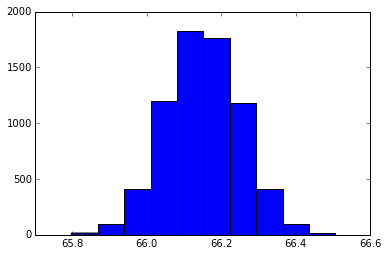

In [36]:
season_average = np.mean(poss_pred.trace(), axis=1)
plt.hist(season_average)

(array([   7.,   30.,  125.,  250.,  515.,  794.,  948.,  862.,  685.,
         451.,  297.,  150.,   82.,   29.,   23.,    6.,    4.,    5.,
           1.,    3.]),
 array([  47.3625 ,   50.03875,   52.715  ,   55.39125,   58.0675 ,
          60.74375,   63.42   ,   66.09625,   68.7725 ,   71.44875,
          74.125  ,   76.80125,   79.4775 ,   82.15375,   84.83   ,
          87.50625,   90.1825 ,   92.85875,   95.535  ,   98.21125,
         100.8875 ]),
 <a list of 20 Patch objects>)

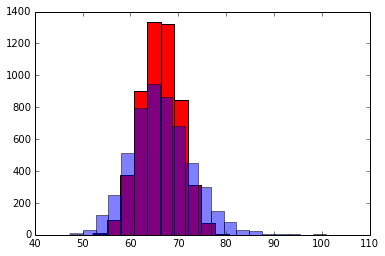

In [43]:
game_dist = np.mean(poss_pred.trace(), axis=0)
plt.hist(game_dist, alpha=1, color='r')
plt.hist(observed_pace, alpha=0.5, bins=20)

In [100]:
pace_rtg.stats().keys()

['95% HPD interval',
 'n',
 'quantiles',
 'standard deviation',
 'mc error',
 'mean']

In [101]:
teams['pace_var'] = pace_rtg.stats()['standard deviation']

['Baylor' 'Iowa' 'Virginia' 'Michigan St.' 'Northwestern' 'Indiana'
 'Nebraska' 'Penn St.' 'Wisconsin' 'Minnesota']



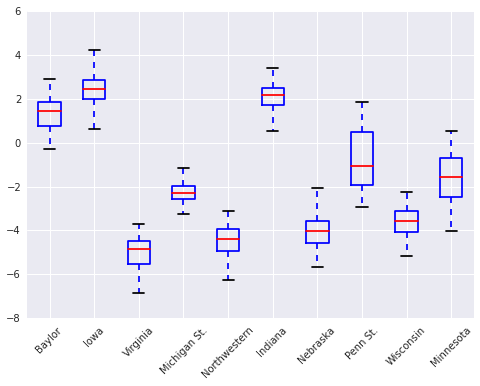

In [117]:
fig, ax = plt.subplots(1, 1)
trace = pace_rtg.trace()
df = pd.DataFrame(trace)
df.head()
data_to_plot = df.iloc[:, :10].values
tms = teams.ncaa[:10].values
print tms
ax.boxplot(data_to_plot)
ax.set_xticklabels(tms, rotation=45)
print